In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import heapq

## Exercise 1: Read in the data & initialize the parameters of the network

In [2]:
def Normalization(X):
    mean_X = X.mean(axis=0)
    std_X = X.std(axis=0)
    return (X - mean_X) / std_X

In [3]:
def LoadBatch(filename):
    with open('Dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')

        X = (dict[b"data"] / 255).T
        y = dict[b"labels"]
        Y = (np.eye(10)[y]).T

    return X, Y, y

In [4]:
def initialization(input_dim, hidden_dim, output_dim, seed = 233):
    # Define standard deviation for random weights and bias normal distribution
    
    scale1 = 1/np.sqrt(input_dim)
    scale2 = 1/np.sqrt(hidden_dim)
    
    # Define random seed and initialize weights
    np.random.seed(seed)
    W1 = np.random.normal(size=(hidden_dim, input_dim), loc=0, scale=scale1)
    W2 = np.random.normal(size=(output_dim, hidden_dim), loc=0, scale=scale2)

    # Initialize bias with zeros
    b1 = np.zeros(shape=(hidden_dim,1))
    b2 = np.zeros(shape=(output_dim,1))
    
    return W1, b1, W2, b2

In [5]:
X,Y,y = LoadBatch('data_batch_1')
X = Normalization(X)
W1, b1, W2, b2 = initialization(3072, 50, 10)
Xtest, Ytest, ytest = LoadBatch('test_batch')
Xtest = Normalization(Xtest)

In [6]:
W1.shape, b1.shape, W2.shape, b2.shape

((50, 3072), (50, 1), (10, 50), (10, 1))

## Exercise 2: Compute the gradients for the network parameters

In [7]:
def ReLu(S):
    H = S
    H[H<0] = 0
    return H

def softmax(S):
    E = np.exp(S)
    P = E/E.sum(axis=0)
    return P
    
def EvaluateClassifier(X, W1, b1, W2, b2):
    S1 = W1@X+b1
    H = ReLu(S1)
    S = W2@H+b2
    P = softmax(S)
    return P, H

In [8]:
def ComputeCost(X, Y, W1, b1, W2, b2, lambda_):
    # Compute the predictions
    P, H = EvaluateClassifier(X, W1, b1, W2, b2)
    
    # Compute the loss function term
    loss_cross = sum(-np.log((Y*P).sum(axis=0)))
    
    # Compute the regularization term
    loss_regularization = lambda_*((W1**2).sum()+(W2**2).sum())
    
    # Sum the total cost
    J = loss_cross/X.shape[1]+loss_regularization
    return J

In [9]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    # Compute the predictions
    P, H = EvaluateClassifier(X, W1, b1, W2, b2)
    
    # Compute the accuracy
    acc = np.mean(y==np.argmax(P, 0))
    return acc

In [10]:
def ComputeGradients(X, Y, P, H, W1, W2, lambda_):
    n = X.shape[1]
    C = Y.shape[0]
    M = H.shape[0]
    G = P-Y
    grad_W2 = (G@H.T)/n+2*lambda_*W2
    grad_b2 = (G@np.ones(shape=(n,1))/n).reshape(C, 1)
    G = W2.T@G
    G = G*(H>0)
    grad_W1 = (G@X.T)/n+2*lambda_*W1
    grad_b1 = (G@np.ones(shape=(n,1))/n).reshape(M, 1)
    return [grad_W2, grad_b2, grad_W1, grad_b1]

In [11]:
def ComputeGradsNum(X, Y, W1, b1, W2, b2, lambda_, h=0.00001):
    grad_W2 = np.zeros(shape=W2.shape)
    grad_b2 = np.zeros(shape=b2.shape)
    grad_W1 = np.zeros(shape=W1.shape)
    grad_b1 = np.zeros(shape=b1.shape)   
    c = ComputeCost(X, Y, W1, b1, W2, b2, lambda_)
    
    for i in range(b1.shape[0]):
        b1_try = b1.copy()
        b1_try[i,0] = b1_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1_try, W2, b2, lambda_)
        grad_b1[i,0] = (c2-c)/h
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1_try = W1.copy()
            W1_try[i,j] = W1_try[i,j]+h
            c2 = ComputeCost(X, Y, W1_try, b1, W2, b2, lambda_)
            grad_W1[i,j] = (c2-c)/h
    
    for i in range(b2.shape[0]):
        b2_try = b2.copy()
        b2_try[i,0] = b2_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1, W2, b2_try, lambda_)
        grad_b2[i,0] = (c2-c)/h
    
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = W2.copy()
            W2_try[i,j] = W2_try[i,j]+h
            c2 = ComputeCost(X, Y, W1, b1, W2_try, b2, lambda_)
            grad_W2[i,j] = (c2-c)/h
    
    return [grad_W2, grad_b2, grad_W1, grad_b1]

In [12]:
def test_grad(X, Y, W1, W2, b1, b2, lambda_):
    # Compute the gradients analytically
    P, H = EvaluateClassifier(X, W1[:,0:20], b1, W2, b2)
    analytically_grad = ComputeGradients(X, Y, P, H, W1[:,0:20], W2, lambda_)

    # Compute the gradients numerically
    numerically_grad = ComputeGradsNum(X, Y, W1[:,0:20], b1, W2, b2, lambda_,
                                                             h=0.000001)
    try:
        for i in range(4):
            np.testing.assert_almost_equal(analytically_grad[i], numerically_grad[i], decimal=6)
    except:
        return
    print("Gradients can work.")

In [13]:
# Take a part of data
X = X[0:20,[0]]
Y = Y[:,[0]]
lambda_ = 0

In [14]:
# Check the gradients.
test_grad(X, Y, W1, W2, b1, b2, lambda_)

Gradients can work.


## Exercise 3: Train your network with cyclical learning rates

In [13]:
def Separate_mini_batch(Xtrain,Ytrain, n_batch):
    Xbatches = []
    Ybatches = []
    for j in range(1,int(Xtrain.shape[1]/n_batch)+1):
        start = (j-1)*n_batch
        end = j*n_batch
        Xbatch = Xtrain[:,start:end]
        Ybatch = Ytrain[:,start:end]
        Xbatches.append(Xbatch)
        Ybatches.append(Ybatch)
    return Xbatches,Ybatches

In [14]:
def train_network(X, Y, y, parameters, Weight_1, Weight_2, bias_1, bias_2, X_val=None, Y_val=None, y_val=None, lambda_=0,
                  return_etas=False, report_process=True):
    n = X.shape[1]
    eta_min = parameters['eta_min']
    eta_max = parameters['eta_max']
    eta_range = eta_max - eta_min
    step_size = parameters['step_size']
    n_batch = parameters['n_batch']
    cycles = parameters['cycles']

    W1, W2, b1, b2 = Weight_1, Weight_2, bias_1, bias_2

    training_result = {'updates': [-1],
               'loss_train': [ComputeCost(X, Y, W1, b1, W2, b2, lambda_)],
               'acc_train': [ComputeAccuracy(X, y, W1, b1, W2, b2)]}

    if X_val is not None:
        X_val = Normalization(X_val)
        training_result['loss_val'] = [ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambda_)]
        training_result['acc_val'] = [ComputeAccuracy(X_val, y_val, W1, b1, W2, b2)]

    X = Normalization(X)
    Xbatches, Ybatches = Separate_mini_batch(X, Y, n_batch)

    max_batch_index = n // n_batch - 1
    costs_train = []
    costs_validation = []

    if return_etas:
        etas = []
        update_step = []

    batch_index = 0
    for cycle in range(cycles):

        for t in range(2 * cycle * step_size, 2 * (cycle + 1) * step_size):

            if t >= 2 * cycle * step_size and t < (2 * cycle + 1) * step_size:
                eta = eta_min + (t - 2 * cycle * step_size) / step_size * eta_range

            elif t >= (2 * cycle + 1) * step_size and t < 2 * (cycle + 1) * step_size:
                eta = eta_max - (t - (2 * cycle + 1) * step_size) / step_size * eta_range

            if return_etas:
                etas.append(eta)
                update_step.append(t + 1)

            P, H = EvaluateClassifier(Xbatches[batch_index], W1, b1, W2, b2)

            grad_W2, grad_b2, grad_W1, grad_b1 = ComputeGradients(Xbatches[batch_index], Ybatches[batch_index], P, H,
                                                                  W1, W2, lambda_)

            W1 += -eta * grad_W1
            b1 += -eta * grad_b1
            W2 += -eta * grad_W2
            b2 += -eta * grad_b2

            batch_index += 1
            if batch_index > max_batch_index:
                batch_index = 0

                training_result['updates'].append(t + 1)
                training_result['acc_train'].append(ComputeAccuracy(X, y, W1, b1, W2, b2))
                training_result['loss_train'].append(ComputeCost(X, Y, W1, b1, W2, b2, lambda_))
                if X_val is not None:
                    training_result['acc_val'].append(ComputeAccuracy(X_val, y_val, W1, b1, W2, b2))
                    training_result['loss_val'].append(ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambda_))

                # Show process info of training
                info = "In update " + str(t + 1) + '/' + str(2 * cycles * step_size) + " finishes epoch " + \
                       str(len(training_result['updates']) - 1) + ": loss=" + str(training_result['loss_train'][-1]) + \
                       " and accuracy=" + str(training_result['acc_train'][-1]) + " (training set) \r"
                if report_process == True:
                    print(info)

    if return_etas:
        return W1, b1, W2, b2, training_result, etas, update_step
    else:
        return W1, b1, W2, b2, training_result

In [15]:
def plot_training_performance(training_result, save_path = None):
    _, plots = plt.subplots(1, 2, figsize=(15, 5))
    for plot_type, ax in zip(['loss', 'acc'], plots.flatten()):
        best_epoch_train = np.argmin(training_result[plot_type + '_train']) if plot_type == 'loss' else np.argmax(
            training_result[plot_type + '_train'])
        optimal_value_train = np.round(training_result[plot_type + '_train'][best_epoch_train], 5)

        label = 'Training: ' + 'optimization is ' + str(optimal_value_train) + ' when update ' + str(
            training_result['updates'][best_epoch_train])
        ax.plot(training_result['updates'], training_result[plot_type + '_train'], color='g', label=label)

        best_epoch_val = np.argmin(training_result[plot_type + '_val']) if plot_type == 'loss' else np.argmax(
            training_result[plot_type + '_val'])
        optimal_value_val = np.round(training_result[plot_type + '_val'][best_epoch_val], 5)

        label = 'Validation: ' + 'optimization is ' + str(optimal_value_val) + ' when update ' + str(
            training_result['updates'][best_epoch_val])
        ax.plot(training_result['updates'], training_result[plot_type + '_val'], color='r', label=label)

        ax.set_xlabel("Update step")
        ax.set_ylabel('Accuracy' if plot_type == 'acc' else 'Loss')
        ax.legend()
        if save_path is not None:
            plt.savefig(save_path)

In [20]:
lambda_ = 0.01
W1, b1, W2, b2 = initialization(3072, 50, 10)
X,Y,y = LoadBatch('data_batch_1')
X_v, Y_v, y_v = LoadBatch('data_batch_2')
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':500, 'cycles':1}

W1, b1, W2, b2, training_result = train_network(X, Y, y, parameters,
                                                     W1, W2, b1, b2, lambda_=lambda_, X_val=X_v,
                                                     Y_val=Y_v, y_val=y_v)

In update 100/1000 finishes epoch 1: loss=2.361507866780499 and accuracy=0.3714 (training set) 
In update 200/1000 finishes epoch 2: loss=2.1288773710408075 and accuracy=0.4402 (training set) 
In update 300/1000 finishes epoch 3: loss=1.9568363477826844 and accuracy=0.4753 (training set) 
In update 400/1000 finishes epoch 4: loss=1.8260466984414916 and accuracy=0.5011 (training set) 
In update 500/1000 finishes epoch 5: loss=1.7300812899381688 and accuracy=0.5153 (training set) 
In update 600/1000 finishes epoch 6: loss=1.6238583067654906 and accuracy=0.5415 (training set) 
In update 700/1000 finishes epoch 7: loss=1.5435370332655147 and accuracy=0.5717 (training set) 
In update 800/1000 finishes epoch 8: loss=1.4751064349762972 and accuracy=0.5952 (training set) 
In update 900/1000 finishes epoch 9: loss=1.4172663961049388 and accuracy=0.6259 (training set) 
In update 1000/1000 finishes epoch 10: loss=1.382621941213659 and accuracy=0.6471 (training set) 


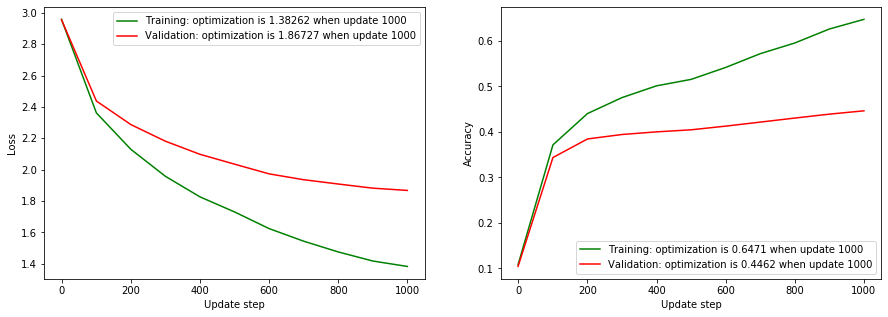

In [25]:
plot_training_performance(training_result, 'Figures/lab2/lab2_plot1.png')

## Exercise 4: Train your network for real

In [23]:
lambda_ = 0.01
W1, b1, W2, b2 = initialization(3072, 50, 10)
X,Y,y = LoadBatch('data_batch_1')
X_v, Y_v, y_v = LoadBatch('data_batch_2')
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'step_size':800, 'cycles':3}

W1, b1, W2, b2, training_result = train_network(X, Y, y, parameters,
                                                     W1, W2, b1, b2, lambda_=lambda_, X_val=X_v,
                                                     Y_val=Y_v, y_val=y_v)

In update 100/4800 finishes epoch 1: loss=2.4301437542912474 and accuracy=0.3536 (training set) 
In update 200/4800 finishes epoch 2: loss=2.202125267321171 and accuracy=0.4289 (training set) 
In update 300/4800 finishes epoch 3: loss=2.039963460959942 and accuracy=0.4663 (training set) 
In update 400/4800 finishes epoch 4: loss=1.9065303900080752 and accuracy=0.4926 (training set) 
In update 500/4800 finishes epoch 5: loss=1.7971486387538185 and accuracy=0.5153 (training set) 
In update 600/4800 finishes epoch 6: loss=1.7120013743319786 and accuracy=0.5287 (training set) 
In update 700/4800 finishes epoch 7: loss=1.6510579577341427 and accuracy=0.5388 (training set) 
In update 800/4800 finishes epoch 8: loss=1.6214887478323718 and accuracy=0.5417 (training set) 
In update 900/4800 finishes epoch 9: loss=1.5494809826900031 and accuracy=0.5644 (training set) 
In update 1000/4800 finishes epoch 10: loss=1.4996055258858532 and accuracy=0.5824 (training set) 
In update 1100/4800 finishes e

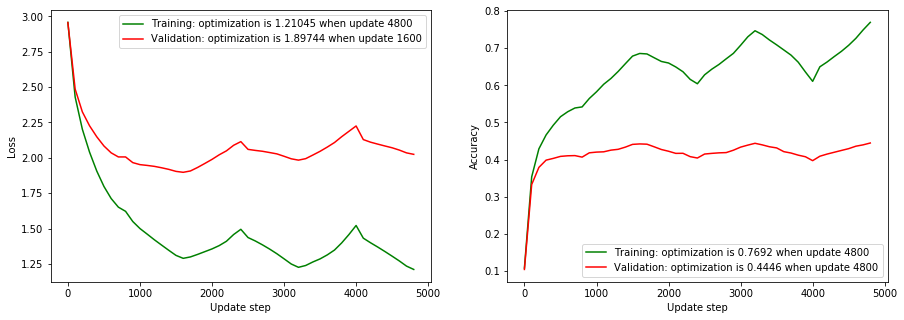

In [18]:
# Plot the learning curve
plot_training_performance(training_result, 'Figures/lab2/lab2_plot2.png')

### Coarse-to-fine random search to set $\lambda$

In [41]:
def lambda_search(lambdas, repeat, hidden_dimension, X, Y, y, parameters, X_val=None,
                  Y_val=None, y_val=None):
    
    lambda_result = {'lambdas': [], 'loss_train_mean': [], 'acc_train_mean': [], 'loss_train_std': [],
                       'acc_train_std': []}
    if X_val is not None:
        lambda_result['loss_val_mean'] = []
        lambda_result['acc_val_mean'] = []
        lambda_result['loss_val_std'] = []
        lambda_result['acc_val_std'] = []

    # Search the different lambdas in loop
    for lambda_ in lambdas:

        # Create a dictionary to store the performance train_result of this particular lambda by randomizations
        repeat_exp = {'loss_train': [], 'acc_train': []}
        if X_val is not None:
            repeat_exp['loss_val'] = []
            repeat_exp['acc_val'] = []

        # Repeat experiments
        for r in range(repeat):

            W1, b1, W2, b2 = initialization(X.shape[0], hidden_dimension, Y.shape[0], r * 5)
            W1, b1, W2, b2, train_result = train_network(X, Y, y, parameters, W1, W2, b1, b2, X_val=X_val,
                                                    Y_val=Y_val, y_val=y_val, lambda_=lambda_, report_process=False)

            repeat_exp['loss_train'].append(train_result['loss_train'][-1])
            repeat_exp['acc_train'].append(train_result['acc_train'][-1])
            if X_val is not None:
                repeat_exp['loss_val'].append(train_result['loss_val'][-1])
                repeat_exp['acc_val'].append(train_result['acc_val'][-1])

        lambda_result['lambdas'].append(lambda_)
        lambda_result['loss_train_mean'].append(np.mean(repeat_exp['loss_train']))
        lambda_result['acc_train_mean'].append(np.mean(repeat_exp['acc_train']))
        lambda_result['loss_train_std'].append(np.std(repeat_exp['loss_train']))
        lambda_result['acc_train_std'].append(np.std(repeat_exp['acc_train']))
        if X_val is not None:
            lambda_result['loss_val_mean'].append(np.mean(repeat_exp['loss_val']))
            lambda_result['acc_val_mean'].append(np.mean(repeat_exp['acc_val']))
            lambda_result['loss_val_std'].append(np.std(repeat_exp['loss_val']))
            lambda_result['acc_val_std'].append(np.std(repeat_exp['acc_val']))
        print("Lambda: ", lambda_, " has been searched.")
    return lambda_result

In [66]:
def plot_lambdas_performance(lambda_result, log_scale = True, save_path = None):
    
    _, plots = plt.subplots(1, 2, figsize=(15, 5))
    
    for plot_type, ax in zip(['loss', 'acc'], plots.flatten()):
        
        # Plot training curve
        best_epoch_train = np.argmin(lambda_result[plot_type + '_train_mean']) if plot_type == 'loss' else np.argmax(
            lambda_result[plot_type + '_train_mean'])
        optimal_value_train = np.round(lambda_result[plot_type + '_train_mean'][best_epoch_train], 3)

        label = 'Training: ' + 'optimization is ' + str(optimal_value_train) + ' when lambda is ' + str(
            lambda_result['lambdas'][best_epoch_train])
        
        x = np.log(lambda_result['lambdas']) if log_scale else lambda_result['lambdas']
        y = lambda_result[plot_type+'_train_mean']
        
        ax.plot(x, y, color='g', label=label)
        
        # Plot validation curve
        best_epoch_val = np.argmin(lambda_result[plot_type + '_val_mean']) if plot_type == 'loss' else np.argmax(
            lambda_result[plot_type + '_val_mean'])
        optimal_value_val = np.round(lambda_result[plot_type + '_val_mean'][best_epoch_val], 3)

        label = 'Validation: ' + 'optimization is ' + str(optimal_value_val) + ' when lambda is ' + str(
            lambda_result['lambdas'][best_epoch_val])
        
        x = np.log(lambda_result['lambdas']) if log_scale else lambda_result['lambdas']
        y = lambda_result[plot_type+'_val_mean']
        ax.plot(x, y, color='r', label=label)

        
        ax.set_xlabel("Log Lambdas" if log_scale else "Lambdas")
        ax.set_ylabel('Accuracy' if plot_type == 'acc' else 'Loss')
        ax.legend()
        if save_path is not None:
            plt.savefig(save_path)

In [29]:
X1,Y1,y1 = LoadBatch('data_batch_1')
X2,Y2,y2 = LoadBatch('data_batch_2')
X3,Y3,y3 = LoadBatch('data_batch_3')
X4,Y4,y4 = LoadBatch('data_batch_4')
X5,Y5,y5 = LoadBatch('data_batch_5')
Xtest, Ytest, ytest = LoadBatch('test_batch')

In [30]:
X = np.hstack((X1, X2, X3, X4, X5))
Y = np.hstack((Y1, Y2, Y3, Y4, Y5))
y = np.array(y1+y2+y3+y4+y5)

In [18]:
def split_dataset(X, Y, y, val_num):
    np.random.seed(10)
    val_index = np.random.choice(range(X.shape[1]), val_num, replace=False)
    X_val = Normalization(X[:,val_index])
    Y_val = Y[:,val_index]
    y_val = [y[i] for i in val_index]

    X_train = Normalization(np.delete(X, val_index, 1))
    Y_train = np.delete(Y, val_index, 1)
    y_train = [y[i] for i in range(X.shape[1]) if i not in val_index]
               
    return X_val, Y_val, y_val, X_train, Y_train, y_train

#### Coarse random search

In [34]:
np.random.seed(30)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(10)
coarse_lambdas = list(10**l)
coarse_lambdas.sort()
print(coarse_lambdas)

[4.5144298035108406e-05, 8.714281448909179e-05, 0.00024358321678948287, 0.00033342177450911654, 0.00042340931328290745, 0.0022017959781029353, 0.0037720213678308903, 0.004489434310567925, 0.07086491241497783, 0.09268382940512102]


In [33]:
X_val, Y_val, y_val, X_train, Y_train, y_train = split_dataset(X, Y, y, 5000)
Xtest = Normalization(Xtest)

In [42]:
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'cycles':2}
parameters['step_size'] = int(2*X_train.shape[1]/parameters['n_batch'])

# Search for lambda
lambda_result = lambda_search(coarse_lambdas, repeat=5, hidden_dimension=50, X=X_train, 
                Y=Y_train, y=y_train, parameters=parameters, X_val=X_val,
                Y_val=Y_val, y_val=y_val)

Lambda:  4.5144298035108406e-05  has been searched.
Lambda:  8.714281448909179e-05  has been searched.
Lambda:  0.00024358321678948287  has been searched.
Lambda:  0.00033342177450911654  has been searched.
Lambda:  0.00042340931328290745  has been searched.
Lambda:  0.0022017959781029353  has been searched.
Lambda:  0.0037720213678308903  has been searched.
Lambda:  0.004489434310567925  has been searched.
Lambda:  0.07086491241497783  has been searched.
Lambda:  0.09268382940512102  has been searched.


In [68]:
acc_list = lambda_result['acc_val_mean']
max_3_index = list(map(acc_list.index, heapq.nlargest(3, acc_list)))
max_3_index.sort()
for index in max_3_index:
    print(lambda_result['lambdas'][index], lambda_result['acc_val_mean'][index])

0.0022017959781029353 0.5109600000000001
0.0037720213678308903 0.51068
0.004489434310567925 0.51032


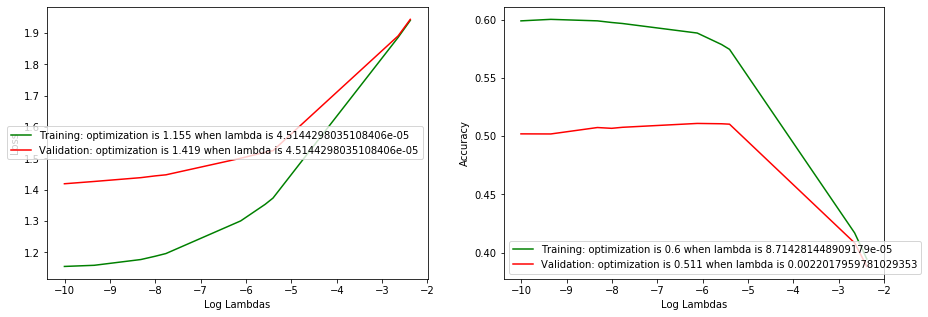

In [67]:
plot_lambdas_performance(lambda_result)

#### Fine random search

In [70]:
fine_lambdas = np.arange(0.001, 0.006, 0.001)
fine_lambdas

array([0.001, 0.002, 0.003, 0.004, 0.005])

In [71]:
X_val, Y_val, y_val, X_train, Y_train, y_train = split_dataset(X, Y, y, 5000)
Xtest = Normalization(Xtest)

In [72]:
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'cycles':3}
parameters['step_size'] = int(2*X_train.shape[1]/parameters['n_batch'])

# Run the search for lambda
lambda_result = lambda_search(fine_lambdas, repeat=5, hidden_dimension=50, X=X_train, 
                Y=Y_train, y=y_train, parameters=parameters, X_val=X_val,
                Y_val=Y_val, y_val=y_val)

Lambda:  0.001  has been searched.
Lambda:  0.002  has been searched.
Lambda:  0.003  has been searched.
Lambda:  0.004  has been searched.
Lambda:  0.005  has been searched.


In [73]:
acc_list = lambda_result['acc_val_mean']
max_3_index = list(map(acc_list.index, heapq.nlargest(3, acc_list)))
max_3_index.sort()
for index in max_3_index:
    print(lambda_result['lambdas'][index], lambda_result['acc_val_mean'][index])

0.003 0.5126799999999999
0.004 0.5140399999999999
0.005 0.5107999999999999


In [74]:
parameters['step_size']

900

## Train the network by best $\lambda$ setting

In [16]:
X1,Y1,y1 = LoadBatch('data_batch_1')
X2,Y2,y2 = LoadBatch('data_batch_2')
X3,Y3,y3 = LoadBatch('data_batch_3')
X4,Y4,y4 = LoadBatch('data_batch_4')
X5,Y5,y5 = LoadBatch('data_batch_5')
Xtest, Ytest, ytest = LoadBatch('test_batch')

X = np.hstack((X1, X2, X3, X4, X5))
Y = np.hstack((Y1, Y2, Y3, Y4, Y5))
y = np.array(y1+y2+y3+y4+y5)

In [19]:
W1, b1, W2, b2 = initialization(3072, 50, 10)
X_val, Y_val, y_val, X_train, Y_train, y_train = split_dataset(X, Y, y, 1000)
Xtest = Normalization(Xtest)
parameters = {'n_batch':100, 'eta_min':1e-5, 'eta_max':1e-1, 'cycles':3}
parameters['step_size'] = int(2*X_train.shape[1]/parameters['n_batch'])

In [22]:
lambda_best = 0.004
W1, b1, W2, b2, training_result = train_network(X_train, Y_train, y_train, parameters,
                                                     W1, W2, b1, b2, lambda_=lambda_best, X_val=X_val,
                                                     Y_val=Y_val, y_val=y_val)

In update 490/5880 finishes epoch 1: loss=1.782471075772566 and accuracy=0.44416326530612243 (training set) 
In update 980/5880 finishes epoch 2: loss=1.6351797375919204 and accuracy=0.4753265306122449 (training set) 
In update 1470/5880 finishes epoch 3: loss=1.5061197596504636 and accuracy=0.5188775510204081 (training set) 
In update 1960/5880 finishes epoch 4: loss=1.4323800448873891 and accuracy=0.5481020408163265 (training set) 
In update 2450/5880 finishes epoch 5: loss=1.4640040313002038 and accuracy=0.5314489795918368 (training set) 
In update 2940/5880 finishes epoch 6: loss=1.524188671989674 and accuracy=0.5072040816326531 (training set) 
In update 3430/5880 finishes epoch 7: loss=1.43663954524661 and accuracy=0.5409591836734694 (training set) 
In update 3920/5880 finishes epoch 8: loss=1.36529394479767 and accuracy=0.5728775510204082 (training set) 
In update 4410/5880 finishes epoch 9: loss=1.4139189582635052 and accuracy=0.5520816326530612 (training set) 
In update 4900/58

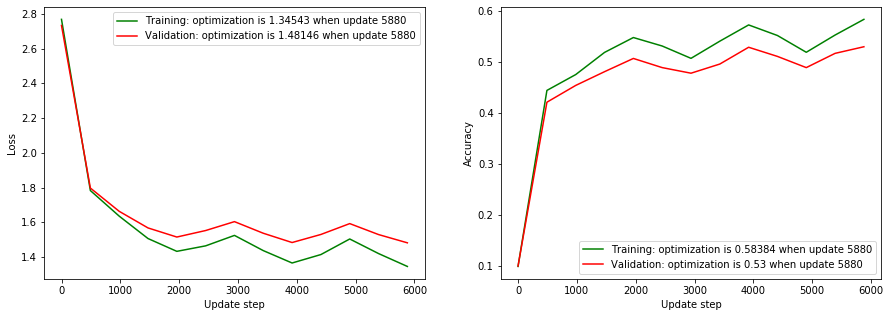

In [24]:
plot_training_performance(training_result, 'Figures/lab2/lab2_plot3.png')

In [27]:
# Compute the accuracy
P, H = EvaluateClassifier(Xtest, W1, b1, W2, b2)
accuracy = ComputeAccuracy(Xtest, ytest, W1, b1, W2, b2)
print(accuracy)

0.5127
